In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from collections import OrderedDict
import file_io
import glob

from shapely.geometry import Point

import matplotlib
matplotlib.rc('image', aspect='auto', interpolation='nearest')

import geopandas
import contextily as ctx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#fname = '/vedbcloud0/staging/2021_04_02_12_30_01/mystream_4_2_12_29_20.csv'
fname = '/vedbcloud0/staging/2021_02_27_11_05_09/mystream_2_27_11_6_25.csv'

In [3]:
syntax = OrderedDict(**{
  1:  ['gps', 'lat', 'lon', 'alt'],     # deg, deg, meters MSL WGS84
  3:  ['accel', 'x', 'y', 'z'],         # m/s/s
  4:  ['gyro', 'x', 'y', 'z'],          # rad/s
  5:  ['mag', 'x', 'y', 'z'],           # microTesla
  6:  ['gpscart', 'x', 'y', 'z'],       # (Cartesian XYZ) meters
  7:  ['gpsv', 'x', 'y', 'z'],          # m/s
  8:  ['gpstime', ''],                  # ms
  81: ['orientation', 'x', 'y', 'z'],   # degrees
  82: ['lin_acc',     'x', 'y', 'z'],
  83: ['gravity',     'x', 'y', 'z'],   # m/s/s
  84: ['rotation',    'x', 'y', 'z'],   # radians
  85: ['pressure',    ''],              # ???
  86: ['battemp', ''],                  # centigrade

# Not exactly sensors, but still useful data channels:
 -10: ['systime', ''],
 -11: ['from', 'IP', 'port'],
})

index_to_column = OrderedDict(**{
  1:  [1, 2, 3],     # deg, deg, meters MSL WGS84
  3:  [4, 5, 6],         # m/s/s
  4:  [7, 8, 9],          # rad/s
  5:  [10, 11, 12],           # microTesla
  6:  [13, 14, 15],       # (Cartesian XYZ) meters
  7:  [16, 17, 18],          # m/s
  8:  [19],                  # ms
  81: [20, 21, 22],   # degrees
  82: [23, 24, 25],
  83: [26, 27, 28],   # m/s/s
  84: [29, 30, 31],   # radians
  85: [32],              # ???
  86: [33],                  # centigrade

# Not exactly sensors, but still useful data channels:
 -10: [34],
 -11: [35, 36],
})

column_keys = list(syntax.keys())
column_names = ['time']
for cname in syntax.values():
    if len(cname) == 2:
        cnames = [cname[0]]
    else:
        cnames = ['_'.join([cname[0], x]) for x in cname[1:]]
    column_names += cnames    

def parse_line(line):
    # 
    out = np.full(len(column_names), np.nan)
    tmp = [x.strip() for x in line.split(',')]
    tmp = [np.float(x) if x is not '' else np.nan for x in tmp]
    out[0] = tmp.pop(0)
    while len(tmp) > 0:
        j = tmp.pop(0)
        if np.isnan(j):
            continue
        j = int(j)
        if not int(j) in column_keys:
            continue
        for jj in index_to_column[j]:
            value = tmp.pop(0)
            #print(jj, column_names[jj], value)
            out[jj] = value
    return out

def parse_file(fname):
    # Read file
    with open(fname) as fid:
        lines = fid.readlines()
    # Parse line by line
    return np.vstack([parse_line(line) for line in lines])

out = parse_file(fname)

In [4]:
out.shape

(9380, 37)

In [5]:
out_labeled = dict(((c, t) for c, t in zip(column_names, out.T)))

In [6]:
igps = ~np.isnan(out_labeled['gps_alt'])

In [7]:
out_labeled['gps_lat'][igps]

array([38.57379 , 38.573756, 38.573737, 38.573722, 38.57371 , 38.573702,
       38.573702, 38.5737  , 38.573698, 38.573695, 38.57369 , 38.573684,
       38.573686, 38.573674, 38.573657, 38.573643, 38.573626, 38.573618,
       38.573607, 38.573664])

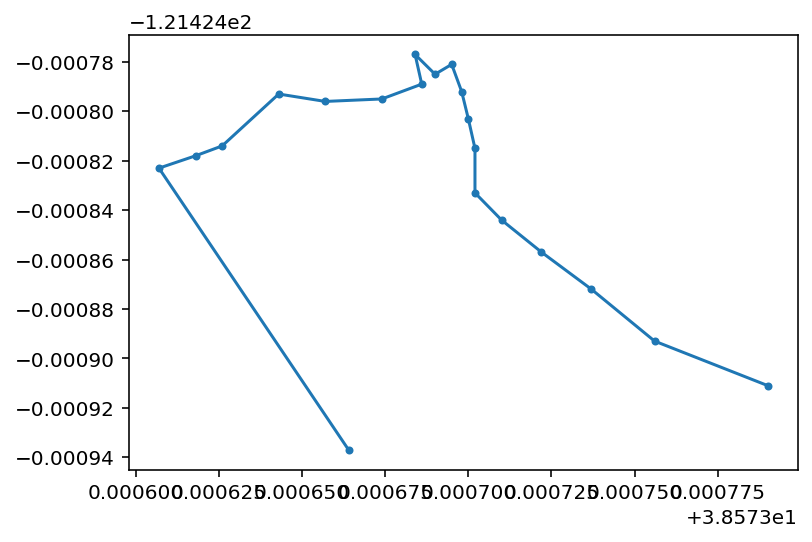

In [8]:
plt.plot(out_labeled['gps_lat'][igps], out_labeled['gps_lon'][igps], '.-')

In [123]:
april2 = parse_file('/vedbcloud0/staging/2021_04_02_12_30_01/mystream_4_2_12_29_20.csv')

In [124]:
april2_labeled = dict(((c, t) for c, t in zip(column_names, april2.T)))

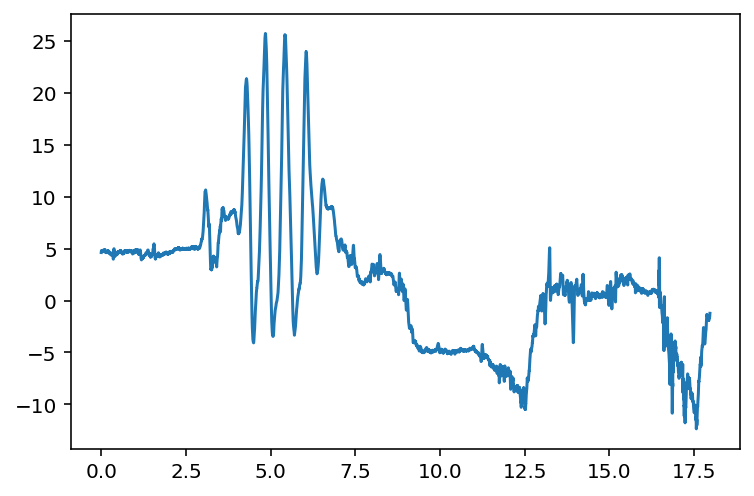

In [128]:
plt.plot(april2_labeled['time'][:120*60]-april2_labeled['time'][0], april2_labeled['accel_y'][:120*60])

/home/mark/.local/lib/python3.6/site-packages/cottoncandy/interfaces.py:63: UserWarning: numcodecs python library not available
  warn('numcodecs python library not available')


In [130]:
acc = file_io.load_msgpack('/vedbcloud0/staging/2021_04_02_12_30_01/accel.pldata')

In [134]:
tt_acc = np.array([x['timestamp'] for x in acc])
acc_xyz = np.array([x['linear_acceleration'] for x in acc])

In [135]:
np.diff(tt_acc).mean()

0.015663907801438996

In [137]:
np.diff(april2_labeled['time']).mean()

0.00558318625400937

In [169]:
gdf = geopandas.read_file('/home/mark/Projects/VEDB/GPS/Reno_city_limits/Reno_City_Limits.shp')

#fig, ax = plt.subplots(figsize=(12,12))
df_mapped = gdf.to_crs(epsg=3857)
ax = df_mapped.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
#ax.plot(out_labeled['gps_lat'][igps], out_labeled['gps_lon'][igps], 'r.-')
ctx.add_basemap(ax)

In [161]:
df = pd.DataFrame(data=dict(Latitude=out_labeled['gps_lat'][igps],
                                Longitude=out_labeled['gps_lon'][igps],
                                ))
crs = {'init':'epsg:4326'}


In [180]:
sacramento = geopandas.read_file('/home/mark/Projects/VEDB/GPS/Sacramento_rivers/Rivers.shp')
sacramento = sacramento.to_crs(epsg=3857)
geo_df_sac = geo_df.to_crs(epsg=3857)

In [188]:
ax.get_ylim()

(4576586.107262315, 4695460.347852414)

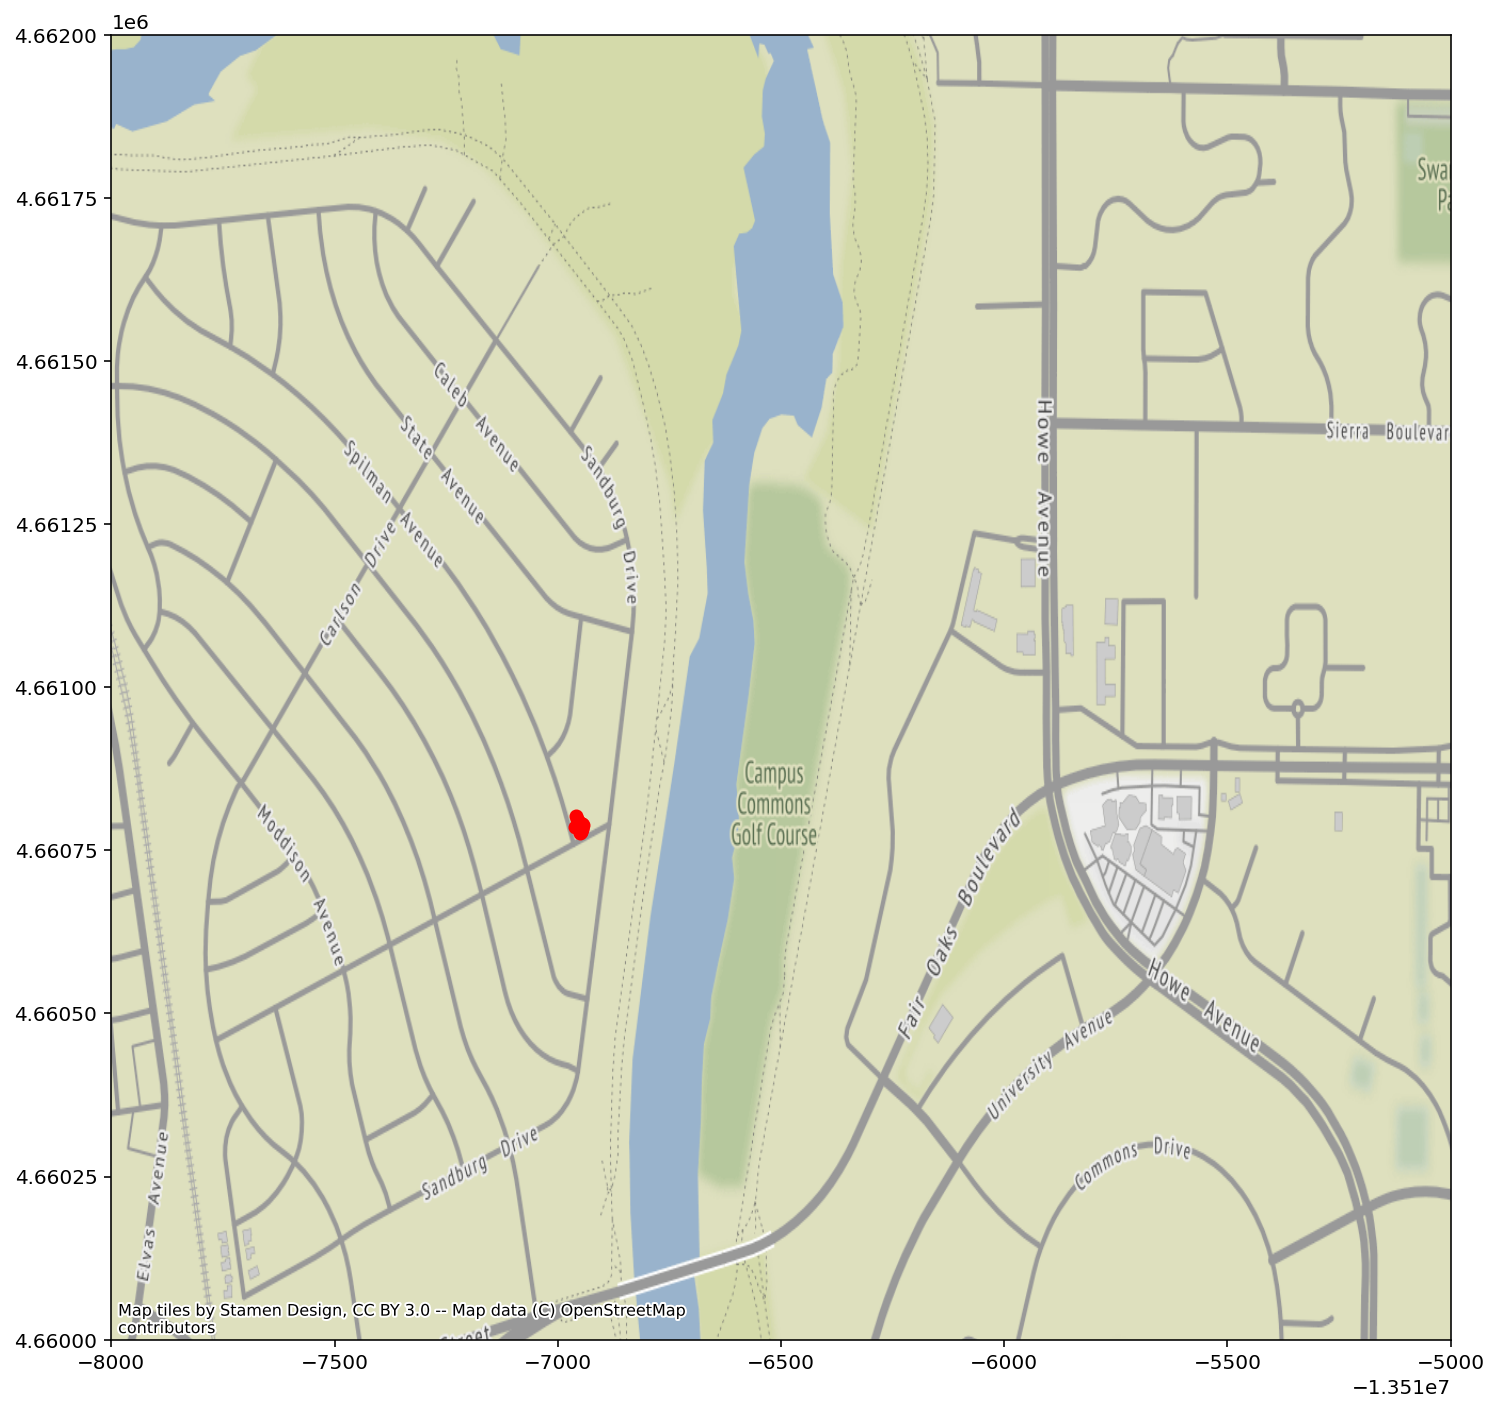

In [198]:
fig, ax = plt.subplots(figsize=(12,12))
#sacramento.plot(ax=ax)

ax = geo_df_sac.plot(ax=ax, color='r')
ax.set_xlim([-1.3518e7, -1.3515e7])
ax.set_ylim([4.660e6, 4.662e6])
ctx.add_basemap(ax)


/usr/local/lib/python3.6/dist-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 39 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


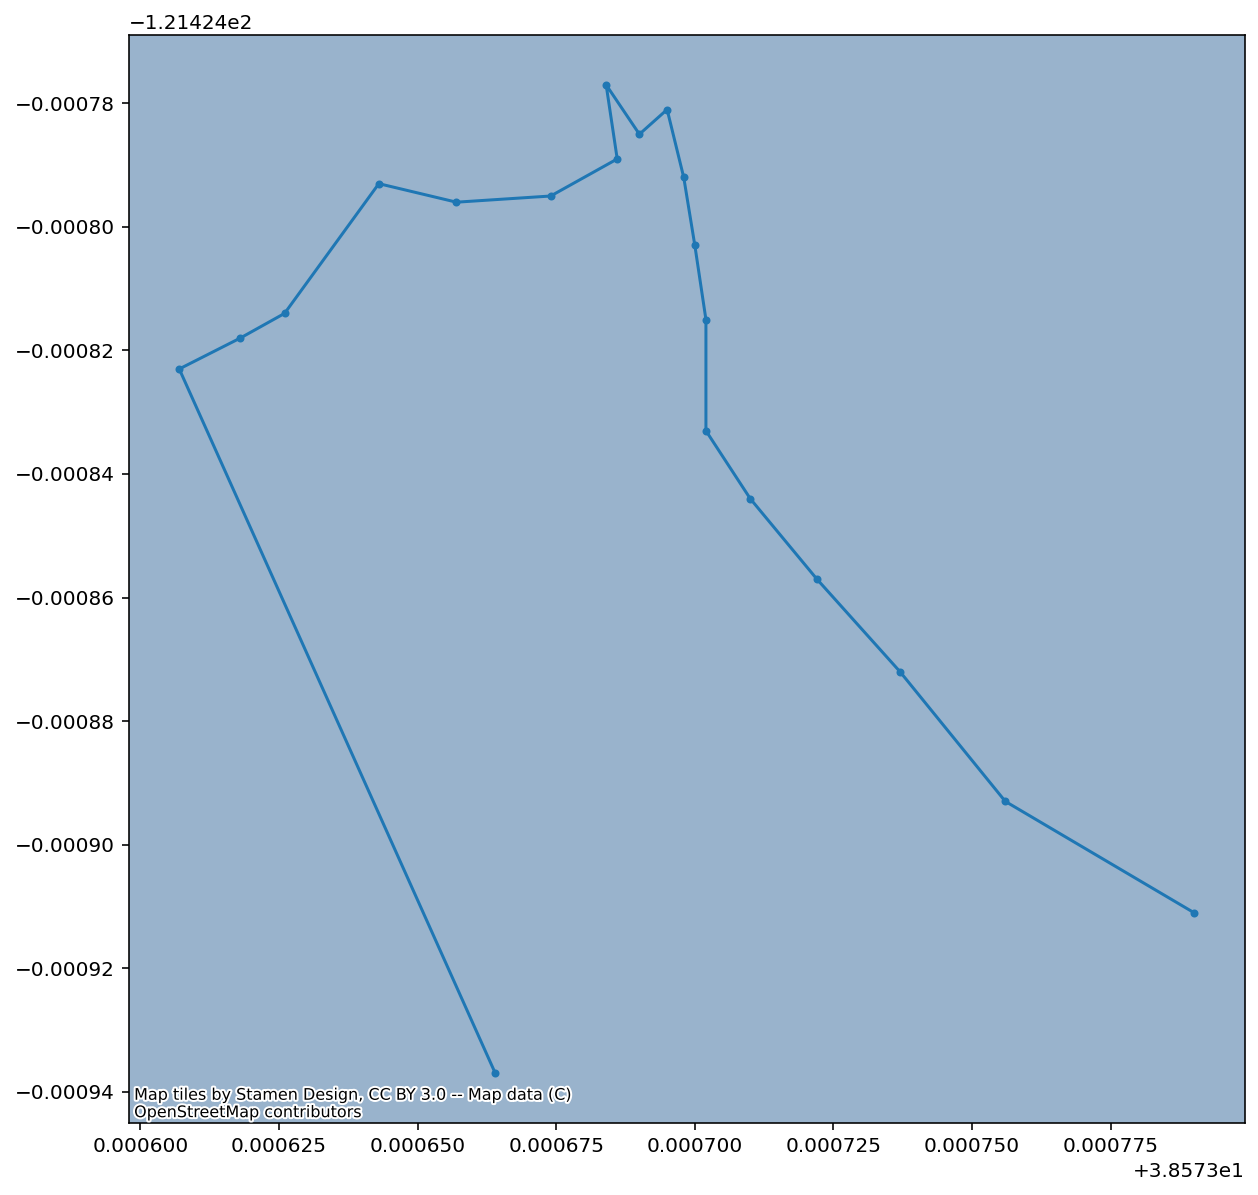

In [152]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(out_labeled['gps_lat'][igps], out_labeled['gps_lon'][igps], '.-')
ctx.add_basemap(ax)

# Checking on timestamps

In [50]:
tt = np.load('/vedbcloud0/staging/2021_04_02_12_30_01/world_timestamps.npy')

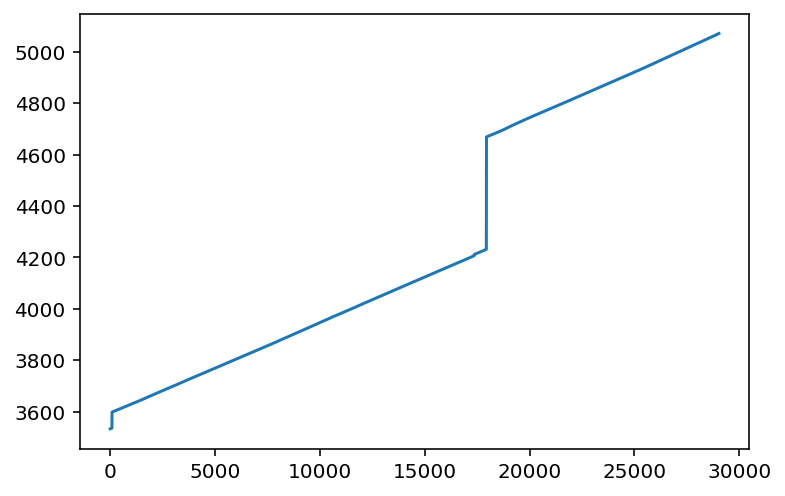

In [51]:
plt.plot(tt)

In [52]:
# Duration from world timestamps (def in seconds), converted to minutes - 25 mins is about right.
(tt.max() - tt.min()) / 60

25.62842052426667

In [53]:
# max duration (if indeed these are timestamps) for GPS data
(timestamp[-1]-timestamp[0]) / 60

50.508387500000005

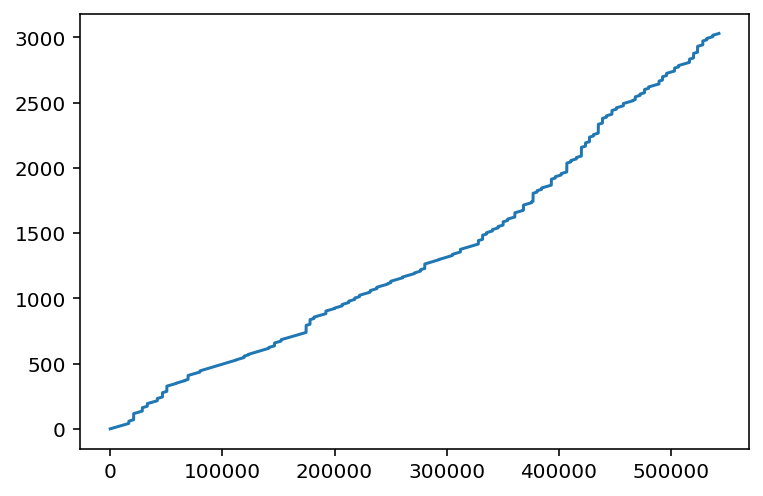

In [54]:
plt.plot((timestamp-timestamp[0]))

# Assess file, column by column

In [55]:
timestamp.min(), timestamp.max()

(1261.68781, 4292.19106)

In [22]:
aa.max(), aa.min() # Why is there a column of 3s? Unclear. 

(3.0, 3.0)

In [39]:
def get_column(data, column, idx=None):
    idxnan = ~np.isnan(data[:,column])
    if idx is not None:
        idxnan &= idx
    return idxnan, data[idxnan, column]

# Parse all available files

In [11]:
files = sorted(glob.glob('/home/mark/Projects/VEDB/GPS/SensorStreamData/*'))

In [12]:
out = {}
for i, f in enumerate(files):
    out[i] = parse_file(f)
    

In [27]:
for i in range(len(files)):
    out_labeled = dict(((c, t) for c, t in zip(column_names, out[i].T)))
    gps_lat = out_labeled['gps_lat']
    gps_long = out_labeled['gps_lon']
    igps = ~np.isnan(gps_lat)
    if np.sum(igps) > 0:
        print(i, 'OK!')
        print(np.nanmean(gps_long))
    else:
        print(i, 'DAAAAAAMN')


0 OK!
-119.89359144444444
1 DAAAAAAMN
2 OK!
-121.42558385714284
3 DAAAAAAMN
4 DAAAAAAMN
5 DAAAAAAMN
6 DAAAAAAMN
7 DAAAAAAMN
8 DAAAAAAMN
9 DAAAAAAMN
10 DAAAAAAMN
11 DAAAAAAMN
12 DAAAAAAMN
13 DAAAAAAMN
14 DAAAAAAMN
15 DAAAAAAMN
16 DAAAAAAMN


In [36]:
geo_df_map

Latitude   Longitude                           geometry
0  39.537844 -119.893588  POINT (-13346493.166 4799008.564)
1  39.537844 -119.893589  POINT (-13346493.277 4799008.564)
2  39.537844 -119.893588  POINT (-13346493.166 4799008.564)
3  39.537843 -119.893587  POINT (-13346493.054 4799008.419)
4  39.537843 -119.893587  POINT (-13346493.054 4799008.419)
5  39.537842 -119.893586  POINT (-13346492.943 4799008.275)
6  39.537863 -119.893601  POINT (-13346494.613 4799011.306)
7  39.537860 -119.893598  POINT (-13346494.279 4799010.873)
8  39.537861 -119.893599  POINT (-13346494.390 4799011.017)

In [45]:
wut = geo_df_map['geometry'][0]

array([-13346494.61269192,   4799008.27481844])

0 OK!
-13346494.612691917 -13346492.942899553
4799008.274818441 4799011.306064043
(-13346501.29186137, -13346486.2637301)
(4798996.149836032, 4799023.431046452)


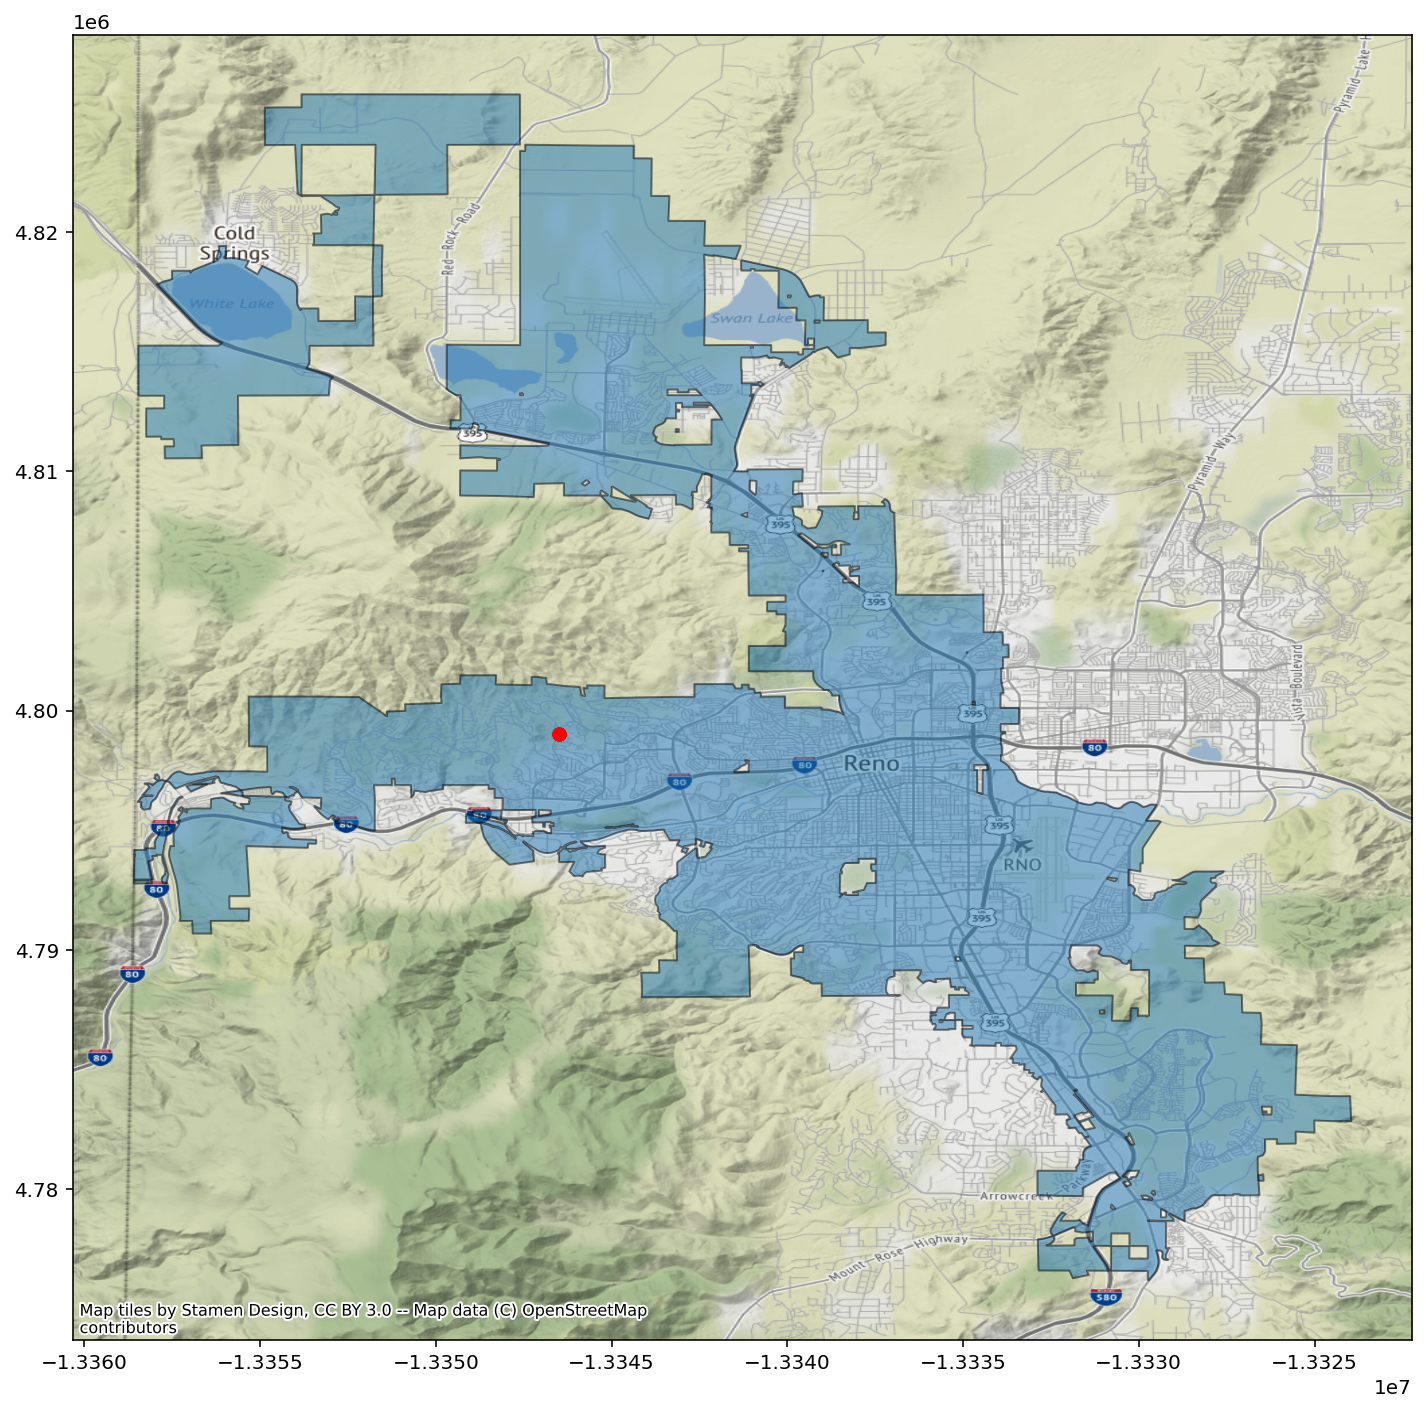

In [73]:
i = 0
out_labeled = dict(((c, t) for c, t in zip(column_names, out[i].T)))
gps_lat = out_labeled['gps_lat']
gps_long = out_labeled['gps_lon']
igps = ~np.isnan(gps_lat)
if np.sum(igps) > 0:
    print(i, 'OK!')
else:
    print(i, 'DAAAAAAMN')

df = pd.DataFrame(data=dict(Latitude=out_labeled['gps_lat'][igps],
                                Longitude=out_labeled['gps_lon'][igps],
                                ))

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geometry[:3]

geo_df = geopandas.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
geo_df_map = geo_df.to_crs(epsg=3857)

mn_long, mn_lat = np.min(np.array([[g.bounds[0], g.bounds[1]] for g in geo_df_map['geometry']]), axis=0)
mx_long, mx_lat = np.max(np.array([[g.bounds[0], g.bounds[1]] for g in geo_df_map['geometry']]), axis=0)

print(mn_long, mx_long)
print(mn_lat, mx_lat)

lat_range = mx_lat - mn_lat
long_range = mx_long - mn_long
sc = 4
ylim = (mn_lat - sc * lat_range, mx_lat + sc * lat_range)
xlim = (mn_long - sc * long_range, mx_long + sc * long_range)


fig, ax = plt.subplots(figsize=(12,12))

reno = geopandas.read_file('/home/mark/Projects/VEDB/GPS/Reno_city_limits/Reno_City_Limits.shp')
reno_map = reno.to_crs(epsg=3857)

sacramento = geopandas.read_file('/home/mark/Projects/VEDB/GPS/Sacramento_rivers/Rivers.shp')
sacramento_map = sacramento.to_crs(epsg=3857)

reno_map.plot(ax=ax, alpha=0.5, edgecolor='k')
#sacramento_map.plot(ax=ax, alpha=0.5, edgecolor='k')
geo_df_map.plot(ax=ax, color='r')
print(xlim)
print(ylim)
#xlim = [-1.3350e7, -1.3345e7]
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)
ctx.add_basemap(ax)

In [65]:
lat_range

3.0312456022948027

In [66]:
long_range

1.6697923634201288